# Imports

In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import ceil, sqrt
import sklearn
from sklearn.metrics import f1_score
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
#from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

# Some global variables

In [3]:
path = 'data/targets/'   #path to .ism files
batch_number = 0
#Get the list of filenames in data/targets/
#ordered by the size of class, descending:
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]
receptors[:5]

[['DRD2.ism', '6229'],
 ['HTR1A.ism', '5592'],
 ['SLC6A4.ism', '5414'],
 ['OPRM1.ism', '5263'],
 ['ADORA1.ism', '4136']]

---

# Functions

## Preparing the dataset

In [4]:
def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    result = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        result.append(smile)
    return result

#### Creating molecule representations

In [5]:
def get_class_vectors(lol_mols, rType):
    ''' For each molecule in the array (list of lists):
        create a binary vector showing which classes it belongs to
        and its representation for training (fingerprint or descriptor)'''

    cv_dict = {}
    for i,l in enumerate(lol_mols):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else:
                    rep = fingerprint(mol) + descriptor(mol)
                
                x = [0]*len(lol_mols)
                cv_dict[smile] = [rep, x]
            cv_dict[smile][1][i] = 1
    return cv_dict

def fingerprint(mol):
    return GetMorganFingerprintAsBitVect(mol,2,1024)

def descriptor(mol):
    funs = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcChiNn,
            CalcChiNv,
            CalcCrippenDescriptors,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for fun in funs:
        descriptors.append(fun(mol))
    return descriptors

In [6]:
def prepare_sets(lol_mols, val_prc=0.25, rType='fingerprint'):
    ''' Create training and validation sets with labels from an array of smiles, shuffling the data '''
    # lol_mols = "list of lists of molecules"
    # mol_l = "list of molecules" <- how about class_i ?
    class_count = len(lol_mols)
    lengths = [len(mol_l) for mol_l in lol_mols]
    starts = [int(l*val_prc) for l in lengths] #start of training sets, end of validation sets
    
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(lol_mols,rType)
    
    # Create the validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols, val_labels = [],[]
    
    for mol_l in lol_mols: # shuffle molecules in each class so that selection for validation is random
        random.shuffle(mol_l)
    
    for i in range(class_count):
        for j in range(starts[i]):
            mol = lol_mols[i][j]
            val_mols.append(molecules[mol][0])
            val_labels.append(molecules[mol][1])
    
    # Shuffle the remaining data and create the training set
    molecules_training = []
    for i,l in enumerate(lol_mols):
        molecules_training += l[starts[i]:]
    
    random.shuffle(molecules_training)
    train_set = [[],[]]
    
    for mol in molecules_training:
        train_set[0].append(molecules[mol][0])
        train_set[1].append(molecules[mol][1])
    
    return train_set, val_mols, val_labels

## Neuron layers

In [7]:
def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.sigmoid(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=1024):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[i], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

In [8]:
def next_batch(data, size): #data = [[fingerprints], [labels]]
    ''' Extract the next batch from a dataset '''
    global batch_number
    batch_number = batch_number%((len(data[0]))//size)
    start = batch_number*size
    batch_number += 1
    return data[0][start:start+size], data[1][start:start+size]

def timer(start,end):
    ''' For timing the training of the network '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

In [9]:
def train_network(data, batch_size, epochs):
    ''' This function trains the network, returning the rate of training and validation accuracy '''
    # Variables:
    global start
    iterations = ceil(len(data[1]) * epochs / batch_size)
    print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    f1 = []
    batch_number = 0
    save_step=0
    # Training:
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        saver.save(session, "tmp/checkpoint", global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            fps, labels = next_batch(data, batch_size)
            session.run(train, feed_dict={x: fps, t: labels})
            
            # Show progress and make a checkpoint
            if i%(iterations//10) == 0:
                progress = int((i/(iterations//10))*10)
                now = timer(start,time.time())
                print("%3i" % progress + '%, ' + str(now))
                save_step += 1
                saver.save(session, "tmp/checkpoint", global_step = save_step)
            
            # Check predictions
            if i % 200 == 0:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: fps, t: labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                f1.append(f1_score(np.array(val_labels), np.array(val_predictions), average='micro'))
        # Final checkpoint
        saver.save(session, "tmp/checkpoint", global_step=save_step+1)
    return tr_rate, val_rate, f1

---

# Script

### Prepare data

In [10]:
num_class = 2 #first n most numerous classes
mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

['CN1CCN(CC1)C2=Cc3ccccc3C(=C(C)C)c4ccccc24',
 'CN1CCN(CC1)C2=Nc3cc(Cl)ccc3Nc4ccccc24',
 'CN1CCC(CC1)C2=Cc3cc(Cl)ccc3Cc4ccccc24']

### Type of representation:

In [11]:
rType = 'fingerprint'

%time train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType)

CPU times: user 4.77 s, sys: 3.76 ms, total: 4.77 s
Wall time: 4.77 s


###  User-defined network variables:

In [17]:
layers = [50]
learning_rate = 0.001
batch_size = 50
epochs = 5

### Create and train the network

In [18]:
#%%time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
start = time.time()
# Automatic network variables
isize = len(val_mols[0])
osize = num_class

active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets

saver = tf.train.Saver(max_to_keep=14)

# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t)) # wypisywać do interpretacji w porównaniu do "głupich" sieci
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction
predict = tf.round(tf.nn.sigmoid(a)) # wektor binarny

# Train the network
tr_rate, val_rate, f1 = train_network(train_set, batch_size, epochs)
full_time = timer(start,time.time())
"--END--"

2017-04-20 18:56:06
946  iterations
  0%, 00:00:00
 10%, 00:00:11
 20%, 00:00:19
 30%, 00:00:30
 40%, 00:00:37
 50%, 00:00:49
 60%, 00:00:56
 70%, 00:01:07
 80%, 00:01:15
 90%, 00:01:26
100%, 00:01:33


'--END--'

### Plot prediction accuracy

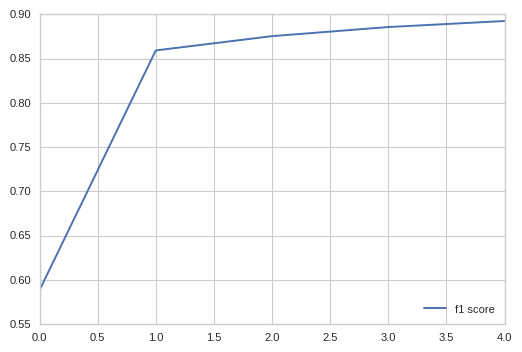

In [19]:
plt.plot(f1, label='f1 score')
plt.legend(loc=4);

Classes:  2, val_rate: 0.7457, Layers: [50], rType: fingerprint
lr_rate: 0.001, batch_size: 50, epochs: 5, time: 00:01:34


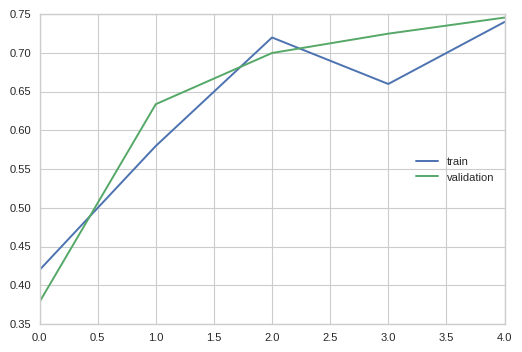

In [20]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {:2}, val_rate: {:.4}, Layers: {}, rType: {}\nlr_rate: {}, batch_size: {}, epochs: {}, time: {}".format(
        osize, max(val_rate), layers, rType, learning_rate, batch_size, epochs, full_time))

---

# Analysis

### Analyze first layer weights

In [16]:
checkpoints = [c for c in sorted(listdir('tmp')) if c[-1]=='0']

weights = []
with tf.Session() as sess:
    for ckpt in checkpoints:
        saver.restore(sess, 'tmp/'+ckpt)
        layer_1 = sess.run(active_layers['w'][0])
        weights.append(layer_1)

weights = np.array(weights)
w_first = weights[0] # first-layer weights before training (first checkpoint)
w_last = weights[-1] # first-layer weights after training (last checkpoint)
weights.shape

(13, 11, 20)

In [17]:
# For each descriptor/fingerprint cell:
# sum of differences of weights between before and after training
# and sum of absolute values of these differences
for i in range(len(w_last)):
    print("{:2}:{:8.3}   {:.3}".format(
        i+1, sum(w_last[i]-w_first[i]), sum(np.absolute(w_last[i]-w_first[i]))
        ))

 1:  0.0188   0.228
 2:  0.0204   0.292
 3:   0.151   0.313
 4: -0.0327   0.25
 5: -0.0157   0.23
 6:  0.0257   0.246
 7: 0.00112   0.186
 8:  0.0266   0.215
 9:  0.0424   0.202
10:   0.022   0.199
11:  -0.116   0.281


In [61]:
c = 2  # descriptor / fingerprint cell to analyse further

In [62]:

print(np.where(w_last[c]-w_first[c] > 0.1))
print(np.where(w_last[c]-w_first[c] < -0.1))

(array([7]),)
(array([], dtype=int64),)


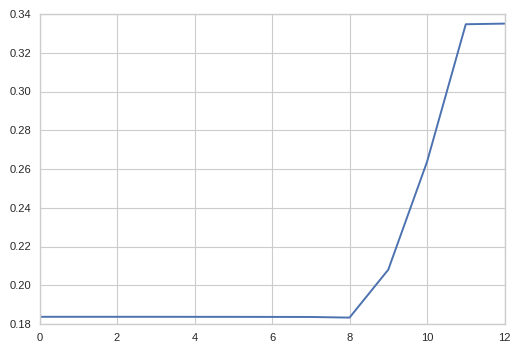

In [63]:
plt.plot(weights[:, c, 7]);

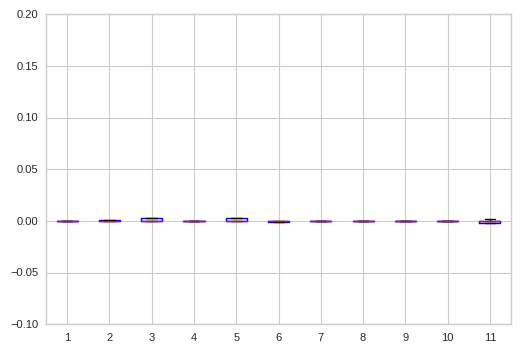

In [56]:
plt.boxplot(np.transpose(w_last-w_first));

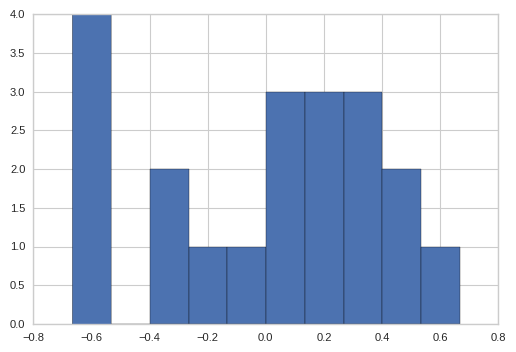

In [64]:
plt.hist(w_last[c]);

---

# Previous learning results

Classes: 15, val_rate: 0.873170063554679, Layers: [100, 50, 30]
lr_rate: 0.0001, batch_size: 25, epochs: 5, vType: descriptor


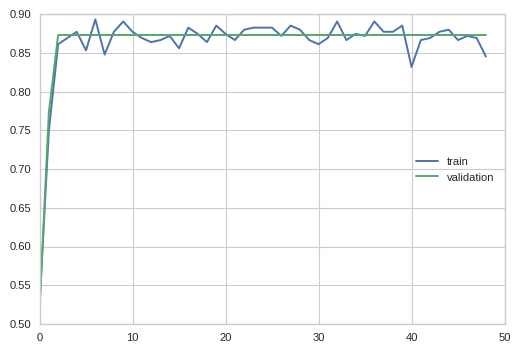

In [58]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}\nlr_rate: {}, batch_size: {}, epochs: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, batch_size, epochs, vType))

Classes: 15, val_rate: 0.8945649791803638, Layers: [100, 50, 30], lr_rate: 0.001, vType: descriptor


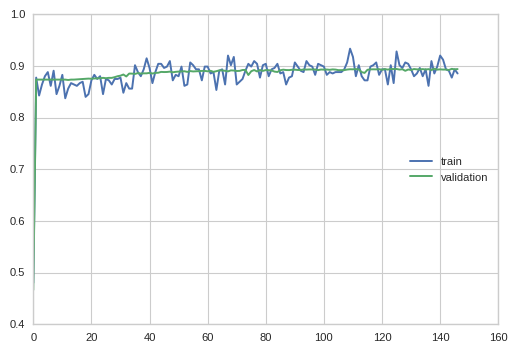

In [14]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

Classes: 15, val_rate: 0.8898586456278764, Layers: [30, 50, 30], lr_rate: 0.001, vType: descriptor


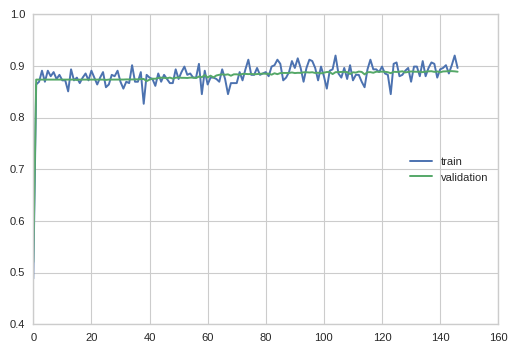

In [12]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

Classes: 15, val_rate: 0.9808459346920886, Layers: [500, 200, 500], lr_rate: 0.01, vType: fingerprint


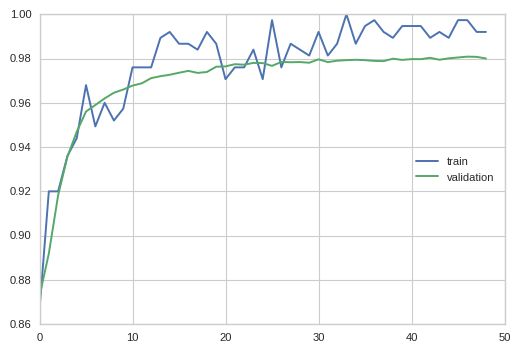

In [55]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

Classes: 15, val_rate: 0.9846756519833443, Layers: [500, 200, 500], lr_rate: 0.001, vType: fingerprint


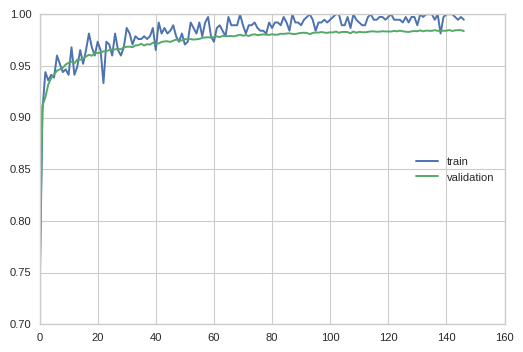

In [14]:
# 15 epochs
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

In [14]:
aa = np.array(
    [[1, 0, 1],
     [1, 0, 1],
     [1, 1, 1],
     [0, 0, 1]]
)
bb = np.array(
    [[0, 0, 1],
     [1, 0, 1],
     [1, 1, 0],
     [0, 0, 1]]
)

In [17]:
f1_score(aa.all(axis=1),bb.all(axis=1), average='micro')

0.75

In [49]:
f1_score(aa,bb, average='micro')

0.8571428571428571